In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
adelaide_df = pd.read_csv('Adelaide_Data.csv')
perth_df = pd.read_csv('Perth_Data.csv')
sydney_df = pd.read_csv('Sydney_Data.csv')
tasmania_df = pd.read_csv('Tasmania_Data.csv')

datasets = [adelaide_df, perth_df, sydney_df, tasmania_df]


In [42]:
# Label columns in every dataset

for dataset in datasets:
    dataset.columns = [f'x{i}' for i in range(1, 17)] + [f'y{i}' for i in range(1, 17)] + [f'p{i}' for i in range(1, 17)] + ['powerall']



adelaide_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,p8,p9,p10,p11,p12,p13,p14,p15,p16,powerall
0,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,83920.1033,80968.0044,87108.1328,68065.1856,99061.3812,77549.1426,99013.1628,78234.4337,84633.6493,1340929.765
1,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,97358.7395,93437.7170,69940.2554,92864.1192,60887.8095,72306.6556,81151.1515,83030.9726,94779.6131,1352031.511
2,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,80399.3841,89349.6141,85048.3860,70038.2271,92797.3569,97653.8121,74903.3740,71690.6549,96220.4768,1396754.375
3,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,97088.1761,81187.3982,63591.6729,92418.1977,82454.8256,97091.7749,85937.5437,66823.1572,93683.0996,1355708.577
4,370.1551,438.7171,222.3375,153.1610,429.7656,478.7805,303.1690,448.9657,98.8592,29.9884,...,97335.9836,70670.4876,57081.2420,86038.3420,83643.1803,97737.5596,85684.3216,57476.9499,85025.9075,1308546.042


In [43]:
# Check for missing values:

for i, dataset in enumerate(datasets):
    missing_count = dataset.isna().sum().sum()
    if missing_count > 0:
        print(f"\nDataset {i} has {missing_count} missing values:")
        print(dataset.isna().sum())
    else:
        print(f"No missing values in dataset {i}")



No missing values in dataset 0
No missing values in dataset 1
No missing values in dataset 2
No missing values in dataset 3


## 05.11.2025
test: xgboost, lightgbm

We want to predict the total power output (described in power_all column) of a set of coordinates



In [44]:
# As we only need x's and y's for predicting power_all, I remove the p1-p16 columns

for dataset in datasets:
    dataset.drop([f'p{i}' for i in range(1, 17)], inplace=True, axis=1)


adelaide_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y8,y9,y10,y11,y12,y13,y14,y15,y16,powerall
0,530.3136,68.7031,31.5983,175.2582,516.1441,63.4652,67.0954,369.4486,14.0930,375.4462,...,248.7212,415.6457,410.1439,156.3712,532.9900,280.7516,559.2803,208.7441,531.3943,1340929.765
1,27.3967,399.0488,565.6854,394.0466,120.2245,558.1293,546.4520,27.3256,314.1051,235.9476,...,498.6277,435.2397,35.5588,148.9206,48.0585,317.9832,26.8732,483.0186,359.0875,1352031.511
2,346.1526,59.6375,226.2742,280.9095,402.2161,218.7181,207.0407,339.5676,0.0000,0.0000,...,217.2239,562.7245,347.2173,0.0000,272.3906,178.4930,317.5044,235.5983,19.6762,1396754.375
3,317.9144,551.8542,335.4745,40.0240,316.6285,365.6434,416.3060,562.1028,211.3577,143.1255,...,536.6741,143.3888,48.6452,109.5254,377.3113,530.8384,463.1129,42.6895,367.9045,1355708.577
4,370.1551,438.7171,222.3375,153.1610,429.7656,478.7805,303.1690,448.9657,98.8592,29.9884,...,423.5370,256.5259,161.7823,0.0000,264.1742,417.7013,349.9758,155.8266,254.7675,1308546.042


In [45]:
# Prepare features (x's and y's) and the target variable for adelaide_df

features = [f'x{i}' for i in range(1, 17)] + [f'y{i}' for i in range(1, 17)]

target = 'powerall'

X = adelaide_df[features].values
y = adelaide_df[target].values


In [46]:
# Split train and test data
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [47]:
# Fit the model
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=37,
)

model.fit(X_train_scaled, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [48]:
# Make predictions on test set
y_pred = model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")    #wychodzi r^2 na minusie czyli cos jest giga zle

Mean Squared Error: 339022754.57
Root Mean Squared Error: 18412.57
R² Score: 0.8927


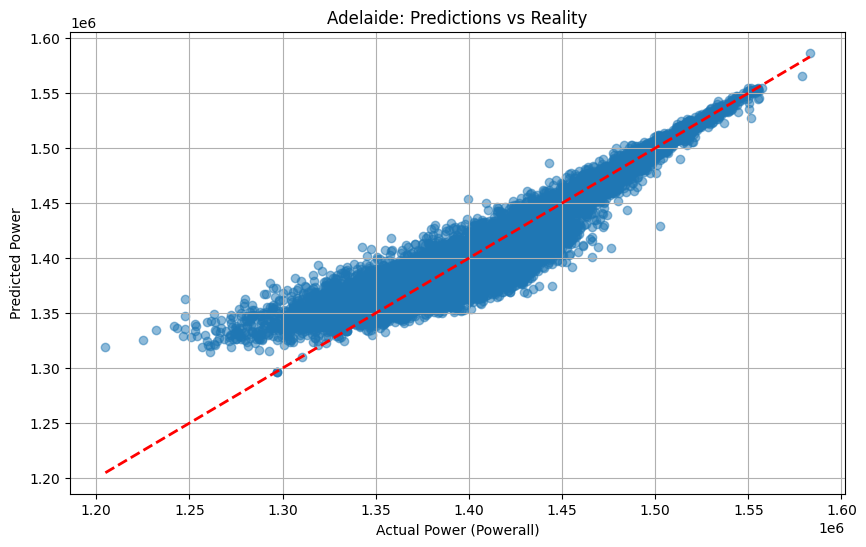

In [49]:
# Visualize predictions vs actual values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Power (Powerall)')
plt.ylabel('Predicted Power')
plt.title('Adelaide: Predictions vs Reality')
plt.grid(True)
plt.show()